In [386]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

# Radial Basis NeuralNet For Feature Creation

In [1012]:
import pandas as pd
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline


#loading Train File
D=pd.read_csv('/home/gaia/GAN/RBF.csv')



data =D
#data['DL PRB UTIL']=data['DL PRB UTIL'].apply(lambda x: 1 if x >= 80 else 0)
y=data['DL PRB UTIL']

y=np.array(y)
data=data.drop('DL PRB UTIL', axis=1)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data
data=pd.DataFrame(scaled_data)

x=np.array(data)
# x=torch.tensor(x).float()
# y=torch.tensor(y).float()
# y=y.view(12710,1)

print(x.shape,y.shape)
#data


(12710, 39) (12710,)


In [990]:
#tx.size()

In [998]:
import torch_rbf as rbf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sys
import numpy as np
import matplotlib.pyplot as plt

# Defining an RBF network class

class MyDataset(Dataset):
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return (x, y)
    
    

class Network(nn.Module):
    
    def __init__(self, layer_widths, layer_centres, basis_func):
        super(Network, self).__init__()
        self.rbf_layers = nn.ModuleList()
        self.linear_layers = nn.ModuleList()
        for i in range(len(layer_widths) - 1):
            self.rbf_layers.append(rbf.RBF(layer_widths[i], layer_centres[i], basis_func))
            self.linear_layers.append(nn.Linear(layer_centres[i], layer_widths[i+1]))
    
    def forward(self, x):
        out = x
        for i in range(len(self.rbf_layers)):
            out = self.rbf_layers[i](out)
            out = self.linear_layers[i](out)
        return out
    


x=x.astype(float)
y=y.astype(float)
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2,shuffle=True , random_state=42)


##Creating Batches of my Train Data for iterations

train_batch = np.array_split(X_train, 100)
label_batch = np.array_split(y_train, 100)
for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i]).float()
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i]).float().view(-1, 1)

X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float().view(-1, 1)


def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal(m.weight)
        #torch.nn.init.kaiming_normal(m.weight,a=0, mode='fan_in', nonlinearity='leaky_relu')
        #m.weight.data.fill_(0)
        m.bias.data.fill_(0.01)

# Instanciating and training an RBF network with the Gaussian basis function
# This network receives a 2-dimensional input, transforms it into a 40-dimensional
# hidden representation with an RBF layer and then transforms that into a
# 1-dimensional output/prediction with a linear layer
# To add more layers, change the layer_widths and layer_centres lists
criterion=nn.MSELoss()
layer_widths = [39,3,1]
layer_centres = [50,3]
basis_func = rbf.multiquadric
torch.manual_seed(39)
rbfnet = Network(layer_widths, layer_centres, basis_func)



model =  Network(layer_widths, layer_centres, basis_func)
model.apply(init_weights)

##Setting up my Criteria
criterion = nn.MSELoss()

##Defining Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 1000

##Running BackProp for Batches

train_losses, test_losses = [], []
for e in range(epochs):
    model.train()
    train_loss = 0
    for i in range(len(train_batch)):
        optimizer.zero_grad()
        output = model(train_batch[i])
        #loss = torch.sqrt(criterion(output, label_batch[i]))
        loss = (criterion(output, label_batch[i]))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    else:
        test_loss = 0
        with torch.no_grad():
            model.eval()
            predictions = model(X_val)
            #test_loss += torch.sqrt(criterion(predictions, y_val))
            test_loss += (criterion(predictions, y_val))
                
        train_losses.append(train_loss/len(train_batch))
        test_losses.append(test_loss)

#         print("Epoch: {}/{}.. ".format(e+1, epochs),
#               "Training Loss: {:.3f}.. ".format(train_loss/len(train_batch)),
#               "Test Loss: {:.3f}.. ".format(test_loss))
        sys.stdout.write('\rEpoch: %d, TrainLoss: %f, TestLoss: %f      ' % \
                                 (e, train_loss/len(train_batch), test_loss))
        sys.stdout.flush()




/home/gaia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


Epoch: 999, TrainLoss: 4.523183, TestLoss: 7.544776        

In [999]:
preds=model(torch.tensor(x[:12710]).float())
#preds
##RMSE
t=torch.from_numpy((y[:12710])).float()
rmse=torch.sqrt(criterion(preds.view(len(preds)),t))
rmse

tensor(2.8210, grad_fn=<SqrtBackward>)

In [1009]:
RBFLayer1out=model.rbf_layers[0](torch.tensor(x[:12710]).float())
LinearLayer1out=model.linear_layers[0](RBFLayer1out)
RBFLAYER=model.rbf_layers[1](LinearLayer1out)
out=RBFLAYER.detach().numpy()

Latentdataset = pd.DataFrame({'Latent1': out[:, 0], 'Latent2': out[:, 1],'Latent3': out[:, 2]})



Latentdataset

,Latent1,Latent2,Latent3
0,29.262928,11.420821,27.515091
1,35.790928,24.437929,30.972757
2,46.276047,52.832405,41.821194
3,37.581810,39.697392,30.469978
4,24.832272,24.488430,21.516878
...,...,...,...
12705,13.452164,31.360014,10.834372
12706,23.801767,40.294205,18.822359
12707,84.360435,88.243874,78.827736
12708,78.920822,83.121017,71.726990


In [1008]:
Latentdataset.columns

Index(['Latent1', 'Latent2', 'Latent3'], dtype='object')

In [1002]:
model

Network(
  (rbf_layers): ModuleList(
    (0): RBF()
    (1): RBF()
  )
  (linear_layers): ModuleList(
    (0): Linear(in_features=50, out_features=3, bias=True)
    (1): Linear(in_features=3, out_features=1, bias=True)
  )
)

In [995]:
Latentdataset.to_csv('/home/gaia/GAN/Lat_22.csv')

In [941]:
model(torch.tensor(x[:10]).float())

tensor([[ 6.4290],
        [22.0441],
        [51.4959],
        [40.8985],
        [20.2473],
        [ 6.7096],
        [ 3.6113],
        [40.3324],
        [29.7094],
        [14.3080]], grad_fn=<AddmmBackward>)

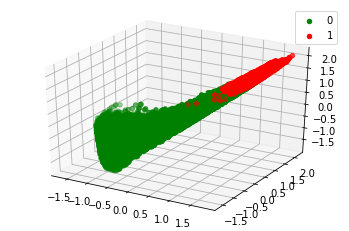

In [1021]:
import numpy as np
from sklearn.manifold import TSNE
#X_embedded = TSNE(n_components=3,init='pca').fit_transform(D_train)
X_embedded=Latentdataset
X_embedded.shape
sc = StandardScaler()
# Fit the scaler to the features and transform
X_embedded_std = sc.fit_transform(X_embedded)

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

scatter_x = X_embedded_std[:, 2]
scatter_y = X_embedded_std[:, 0]
scatter_z= X_embedded_std[:, 1]
#group = np.asarray(D.iloc[:,0])
group = y
cdict = {1: 'red', 0: 'green'}


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_z[ix],scatter_x[ix],scatter_y[ix], c = cdict[g], label = g)
ax.legend()
plt.show()

#s = 100

In [1013]:
y

array([0, 0, 0, ..., 1, 1, 0])

In [1039]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width',
              color='species')
fig.show()

# End

In [ ]:
# import torch_rbf as rbf
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# import sys
# import numpy as np
# import matplotlib.pyplot as plt

# # Defining an RBF network class

# class MyDataset(Dataset):
    
#     def __init__(self, x, y):
#         self.x = x
#         self.y = y
    
#     def __len__(self):
#         return self.x.size(0)
    
#     def __getitem__(self, idx):
#         x = self.x[idx]
#         y = self.y[idx]
#         return (x, y)

# class Network(nn.Module):
    
#     def __init__(self, layer_widths, layer_centres, basis_func):
#         super(Network, self).__init__()
#         self.rbf_layers = nn.ModuleList()
#         self.linear_layers = nn.ModuleList()
#         for i in range(len(layer_widths) - 1):
#             self.rbf_layers.append(rbf.RBF(layer_widths[i], layer_centres[i], basis_func))
#             self.linear_layers.append(nn.Linear(layer_centres[i], layer_widths[i+1]))
    
#     def forward(self, x):
#         out = x
#         for i in range(len(self.rbf_layers)):
#             out = self.rbf_layers[i](out)
#             out = self.linear_layers[i](out)
#         return out
    
#     def fit(self, x, y, epochs, batch_size, lr, loss_func):
#         self.train()
#         obs = x.size(0)
#         trainset = MyDataset(x, y)
#         trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
#         optimiser = torch.optim.Adam(self.parameters(), lr=lr)
#         epoch = 0
#         while epoch < epochs:
#             epoch += 1
#             current_loss = 0
#             batches = 0
#             progress = 0
#             for x_batch, y_batch in trainloader:
#                 batches += 1
#                 optimiser.zero_grad()
#                 y_hat = self.forward(x_batch)
#                 loss = (loss_func(y_hat, y_batch))
                
#                 current_loss += (1/batches) * (loss.item() - current_loss)
                
#                 loss.backward()
#                 optimiser.step()
#                 progress += y_batch.size(0)
#                 sys.stdout.write('\rEpoch: %d, Progress: %d/%d, Loss: %f      ' % \
#                                  (epoch, progress, obs, current_loss))
#                 sys.stdout.flush()




# tx=x
# ty=y

# # Instanciating and training an RBF network with the Gaussian basis function
# # This network receives a 2-dimensional input, transforms it into a 40-dimensional
# # hidden representation with an RBF layer and then transforms that into a
# # 1-dimensional output/prediction with a linear layer

# # To add more layers, change the layer_widths and layer_centres lists
# criterion=nn.MSELoss()
# layer_widths = [39,1]
# layer_centres = [150]
# basis_func = rbf.gaussian

# rbfnet = Network(layer_widths, layer_centres, basis_func)
# rbfnet.fit(tx, ty, 1000, 100, 0.01,criterion)
# rbfnet.eval()
# with torch.no_grad():
#     preds = (rbfnet(torch.from_numpy(tx[:12710]).float())).data.numpy()

# #nn.BCEWithLogitsLoss()

# with torch.no_grad():
#     preds = (rbfnet(torch.from_numpy(np.asarray(tx[0:12710])).float())).data.numpy()
    
#     ##RMSE
# preds=torch.tensor(preds)
# criterion=nn.MSELoss()
# #t=torch.from_numpy(y[:100].values).float()
# t=(y[:12710]).float()
# rmse=torch.sqrt(criterion(preds,t))
# rmse